In [1]:
from netCDF4 import Dataset
import netCDF4
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.basemap import Basemap # Import the Basemap toolkit
import numpy as np # Import the Numpy package
from datetime import datetime
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText
import matplotlib.gridspec as gridspec
import matplotlib.mlab as mlab
import matplotlib.cm as colors
from glob import glob
# from geopy.geocoders import Nominatim
import pandas as pd
import matplotlib.dates as mdates
import seaborn as sns

In [42]:
diri='/scratch/m/m300382/temp/gefs-plots/grib/'

t_2m=[]
t_850hpa=[]
tot_prec=[]
snow=[]
rain=[]
u_10m=[]
v_10m=[]
n_pert=[]

for fname in glob(diri+"*.nc"):
    nc=Dataset(fname)
    t_2m.append(nc.variables['T_2M'][:][:,0,:,:]-273.15)
    t_850hpa.append(nc.variables['T'][:][:,0,:,:]-273.15)
    tot_prec.append(nc.variables['tp'][:])
    snow.append(nc.variables['csnow'][:])
    rain.append(nc.variables['crain'][:])
    u_10m.append(nc.variables['U_10M'][:][:,0,:,:])
    v_10m.append(nc.variables['V_10M'][:][:,0,:,:])
    if (fname[fname.find(".nc")-2:fname.find(".nc")]) =="00": #this is the control run
        n_pert.append(0)
    else:
        n_pert.append(nc.variables['T_2M'].realization)

n_pert=np.array(n_pert)
t_2m=np.array(t_2m)
t_850hpa=np.array(t_850hpa)
tot_prec=np.array(tot_prec)
snow=np.array(snow)
rain=np.array(rain)
wind_speed_10m=np.sqrt(np.array(u_10m)**2+np.array(v_10m)**2)*3.6
lon=nc.variables['lon'][:]
lat=nc.variables['lat'][:]
time_var = nc.variables['time']
dtime = netCDF4.num2date(time_var[:],time_var.units)

In [43]:
t_2m_point={}
t_850hpa_point={}
tot_prec_point={}
snow_point={}
rain_point={}
wind_speed_10m_point={}
# cities = [["Hamburg",53.606753,9.930543],["Pisa",43.716897,10.393928]]
cities = [["Milano",45.464211,9.191383],["Roma",41.8933203,12.4829321],["Palermo",38.1112268,13.3524434]]
# geolocator = Nominatim()
for (city,latitude,longitude) in cities:
    #loc = geolocator.geocode(city)
    t_2m_point[city] = t_2m[:,:,np.argmin(abs(lat-latitude)),np.argmin(abs(lon-longitude))]
    t_850hpa_point[city] = t_850hpa[:,:,np.argmin(abs(lat-latitude)),np.argmin(abs(lon-longitude))]
    tot_prec_point[city] = tot_prec[:,:,np.argmin(abs(lat-latitude)),np.argmin(abs(lon-longitude))]
    snow_point[city] = snow[:,:,np.argmin(abs(lat-latitude)),np.argmin(abs(lon-longitude))]
    rain_point[city] = rain[:,:,np.argmin(abs(lat-latitude)),np.argmin(abs(lon-longitude))]
    wind_speed_10m_point[city] = wind_speed_10m[:,:,np.argmin(abs(lat-latitude)),np.argmin(abs(lon-longitude))]

In [40]:
sns.set(style="white")
#city_to_plot="Roma"
var_to_plot=t_850hpa_point
var2_to_plot=tot_prec_point

for (city_to_plot,latitude,longitude) in cities:
    fig = plt.figure(1, figsize=(9,6))
    plt.plot_date(dtime,var_to_plot[city_to_plot].T,'-',lw=1)
    plt.plot_date(dtime,var_to_plot[city_to_plot].T[:,np.where(n_pert==0)[0]],'-',lw=2.5,color='black')
    plt.ylabel("850 hPa temperature [C]")
    plt.ylim(-25, 20)
    
    plt.gca().minorticks_on()
    plt.gca().grid(which='major', linestyle='-', linewidth='0.5', color='black')
    plt.gca().grid(which='minor', linestyle=':', linewidth='0.3', color='black')
    
    ax2 = plt.gca().twinx()
    ax2.plot_date(dtime,var2_to_plot[city_to_plot].T,'--',lw=1.5)
    ax2.set_ylabel("Precipitation [mm]")
    ax2.set_ylim(0, 50)
    
    plt.title("GEFS forecast for "+city_to_plot+" | Run "+dtime[0].strftime("%Y%m%d %H"))
    fig.autofmt_xdate()
    
    plt.savefig("spaghetti_"+city_to_plot, dpi=150, bbox_inches='tight')
    plt.clf()

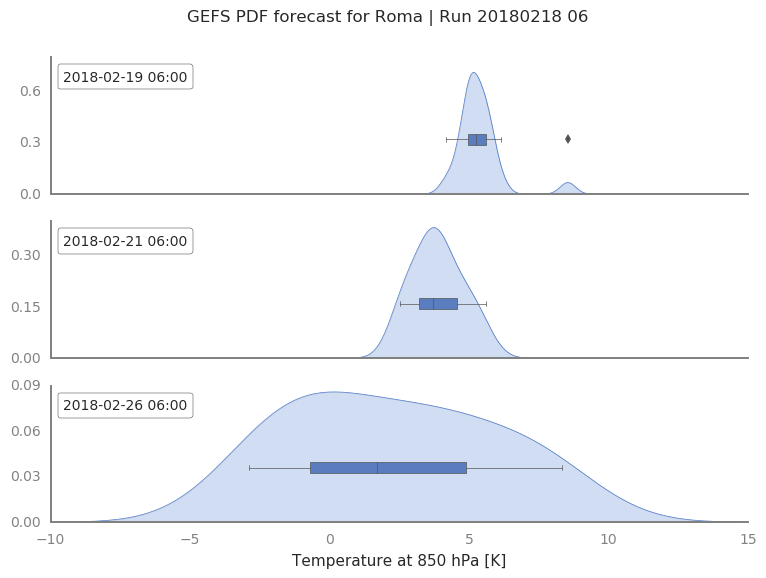

In [377]:
city_to_plot="Roma"
var_to_plot=t_2m_point
myDates= ["2018-02-19 06:00", "2018-02-21 06:00", "2018-02-26 06:00"]

dates = pd.to_datetime(dtime)
df = pd.DataFrame(data=var_to_plot[city_to_plot].T)
df['date']=dates
df = df.set_index(['date'])
df_subset=df.loc[pd.to_datetime(myDates)]

fig = plt.figure(1, figsize=(9, 6))

nrows=np.shape(myDates)[0]
rows=np.arange(start=0, stop=nrows, step=1)
gridspec.GridSpec(nrows,1)

sns.set(style="white", palette="muted", color_codes=True)
sns.set_context(rc={"lines.linewidth": 0.5})
plt.rc_context({'axes.edgecolor':'grey', 'xtick.color':'grey', 'ytick.color':'grey'})
plt.suptitle("GEFS PDF forecast for "+city_to_plot+" | Run "+dtime[0].strftime("%Y%m%d %H"))

for row in rows:
    if row == rows[0]:
        ax1=plt.subplot2grid((nrows,1), (row,0))
    else: 
        plt.subplot2grid((nrows,1), (row,0),sharex=ax1)
    ax2=sns.distplot(df.loc[myDates[row]],hist=False,kde_kws={"shade":True})
    ax3 = ax2.twinx()
    ax3.get_xaxis().set_visible(False)
    sns.boxplot(x=df.loc[myDates[row]],ax=ax3)
    sns.despine()
    ax3.set(ylim=(-4, 6))
    at = AnchoredText(myDates[row], prop=dict(size=10), frameon=True,loc=2)
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    plt.gca().add_artist(at)
    ax2.yaxis.set_major_locator(plt.MaxNLocator(3))
    if row != rows[-1]:
        ax2.get_xaxis().set_visible(False)
    else: 
        ax2.get_xaxis().set_visible(True)
        ax2.set_xlabel('Temperature at 850 hPa [C]')

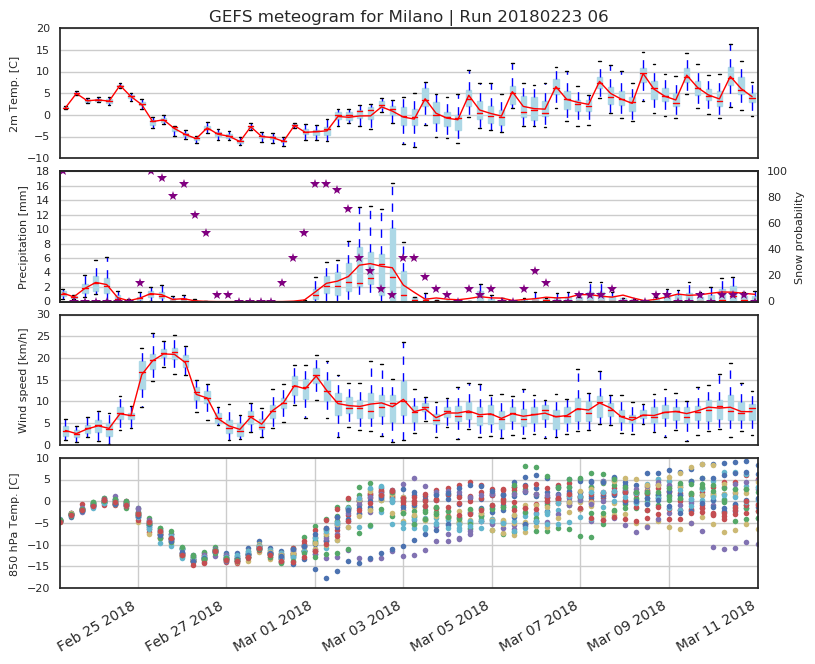

In [71]:
fig = plt.figure(1, figsize=(9,8))

nrows=4
ncols=1
gridspec.GridSpec(nrows,ncols)
city_to_plot="Milano"

# dates = pd.to_datetime(dtime)
# df = pd.DataFrame(data=t_2m_point["Roma"][:,:], columns=dates)
#ax=df.plot.box(showfliers=False, figsize=(12,3))
#ax.plot(xaxis, df.mean(axis=0), linewidth=1,color='red')

ax1=plt.subplot2grid((nrows,ncols), (0,0))
ax1.set_title("GEFS meteogram for "+city_to_plot+" | Run "+dtime[0].strftime("%Y%m%d %H"))
bplot=ax1.boxplot(t_2m_point[city_to_plot],patch_artist=True)
for box in bplot['boxes']:
    box.set(color='LightBlue')
    box.set(facecolor='LightBlue')

xaxis=np.arange(1,np.shape(dtime)[0]+1,1)
ax1.plot(xaxis, np.mean(t_2m_point[city_to_plot], axis=0), linewidth=1,color='red')
ax1.set_ylabel("2m Temp. [C]",fontsize=8)
ax1.yaxis.grid(True)
ax1.tick_params(axis='y', which='major', labelsize=8)

ax2=plt.subplot2grid((nrows,ncols), (1,0))
bplot_rain=ax2.boxplot(tot_prec_point[city_to_plot],patch_artist=True)
for box in bplot_rain['boxes']:
    box.set(color='LightBlue')
    box.set(facecolor='LightBlue')
ax2.plot(xaxis, np.mean(tot_prec_point[city_to_plot], axis=0), linewidth=1,color='red')
ax2b = ax2.twinx()
ax2b.plot(xaxis, np.mean(snow_point[city_to_plot]*100, axis=0), '*', linewidth=1,color='purple')
ax2b.set_ylabel("Snow probability",fontsize=8)
ax2.yaxis.grid(True)
ax2.set_ylabel("Precipitation [mm]",fontsize=8)
ax2.tick_params(axis='y', which='major', labelsize=8)
ax2b.tick_params(axis='y', which='major', labelsize=8)

ax3=plt.subplot2grid((nrows,ncols), (2,0))
bplot_wind=ax3.boxplot(wind_speed_10m_point[city_to_plot],patch_artist=True)
for box in bplot_wind['boxes']:
    box.set(color='LightBlue')
    box.set(facecolor='LightBlue')
ax3.plot(xaxis, np.mean(wind_speed_10m_point[city_to_plot], axis=0), linewidth=1,color='red')
ax3.yaxis.grid(True)
ax3.set_ylabel("Wind speed [km/h]",fontsize=8)
ax3.tick_params(axis='y', which='major', labelsize=8)

ax4=plt.subplot2grid((nrows,ncols), (3,0))
ax4.plot_date(dtime, t_850hpa_point[city_to_plot][:,:].T, markersize=4)
ax4.set_ylabel("850 hPa Temp. [C]",fontsize=8)
ax4.tick_params(axis='y', which='major', labelsize=8)
ax4.yaxis.grid(True)
ax4.xaxis.grid(True)

fig.subplots_adjust(hspace=0.1)
fig.autofmt_xdate()
#plt.suptitle("GEFS meteogram for "+city_to_plot+" | Run "+dtime[0].strftime("%Y%m%d %H"))

plt.show()